# 📊 Paper Figures & Charts Generator

## All visualizations for the Calibrated Gradient–Bayes Voting Ensemble Paper

**This notebook generates:**
1. Dataset overview (Table 1, Figure 1)
2. Calibration comparison (Table 2, Figure 2)
3. Performance metrics (Table 3)
4. Ablation study (Table 4, Figure 3)
5. DistilBERT comparison (Table 5)
6. Confusion matrices
7. ROC & PR curves
8. Feature importance charts

**Loads pre-trained vectorizers and saved results. Re-fits ensemble (fast).**

---

## 1️⃣ Setup & Imports

In [4]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_curve, auc, precision_recall_curve,
    brier_score_loss,
    accuracy_score, f1_score, matthews_corrcoef,
    average_precision_score, log_loss
)
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from sklearn.calibration import CalibratedClassifierCV
from scipy import stats as scipy_stats
from scipy.special import expit
import scipy.sparse as sp
import re
import unicodedata
import warnings
import os
import time
from sklearn.calibration import calibration_curve

warnings.filterwarnings('ignore')

# Set style for publication-quality plots
plt.style.use('seaborn-v0_8-paper')
sns.set_palette('husl')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10
plt.rcParams['figure.figsize'] = (8, 6)

# Create output directory
os.makedirs('paper_figures', exist_ok=True)

print("✅ Setup complete!")
print("📁 Figures will be saved to: paper_figures/")

✅ Setup complete!
📁 Figures will be saved to: paper_figures/


## 2️⃣ Configuration

In [5]:
# =============================================================================
# CONFIGURATION - Paths and model parameters
# =============================================================================
PATHS = {
    'dataset': 'enron_spam_data.csv',
    'models_dir': 'models',
    'ensemble': 'models/calibrated_ensemble.pkl',
    'word_vectorizer': 'models/word_vectorizer.pkl',
    'char_vectorizer': 'models/char_vectorizer.pkl',
    'results': 'models/results.csv',
    'ablation_results': 'models/ablation_results.csv',
}

# Model config (must match training)
CONFIG = {
    'TEST_SIZE': 0.2,
    'RANDOM_STATE': 42,
    'CALIBRATION_CV': 5,
    'SVM_C': 1.0,
    'NB_ALPHA': 1.0,
    'GB_N_ESTIMATORS': 100,
    'GB_LEARNING_RATE': 0.1,
    'GB_MAX_DEPTH': 3,
    'GB_SUBSAMPLE': 0.8,
    'ENSEMBLE_WEIGHTS': [2, 1, 2],  # SVM, NB, GB
}

print("📋 Configuration loaded")

📋 Configuration loaded


## 3️⃣ Load Dataset

In [6]:
print("Loading dataset...")

df = pd.read_csv(PATHS['dataset'])
df['text'] = (df['Subject'].fillna('') + ' ' + df['Message'].fillna('')).str.strip()
df = df[df['text'].str.len() > 0].reset_index(drop=True)
df['label'] = (df['Spam/Ham'] == 'spam').astype(int)
df['msg_length'] = df['text'].str.split().str.len()

print(f"✅ Dataset loaded: {len(df):,} emails")
print(f"   Spam: {(df['label']==1).sum():,} | Ham: {(df['label']==0).sum():,}")

Loading dataset...
✅ Dataset loaded: 33,665 emails
   Spam: 17,120 | Ham: 16,545


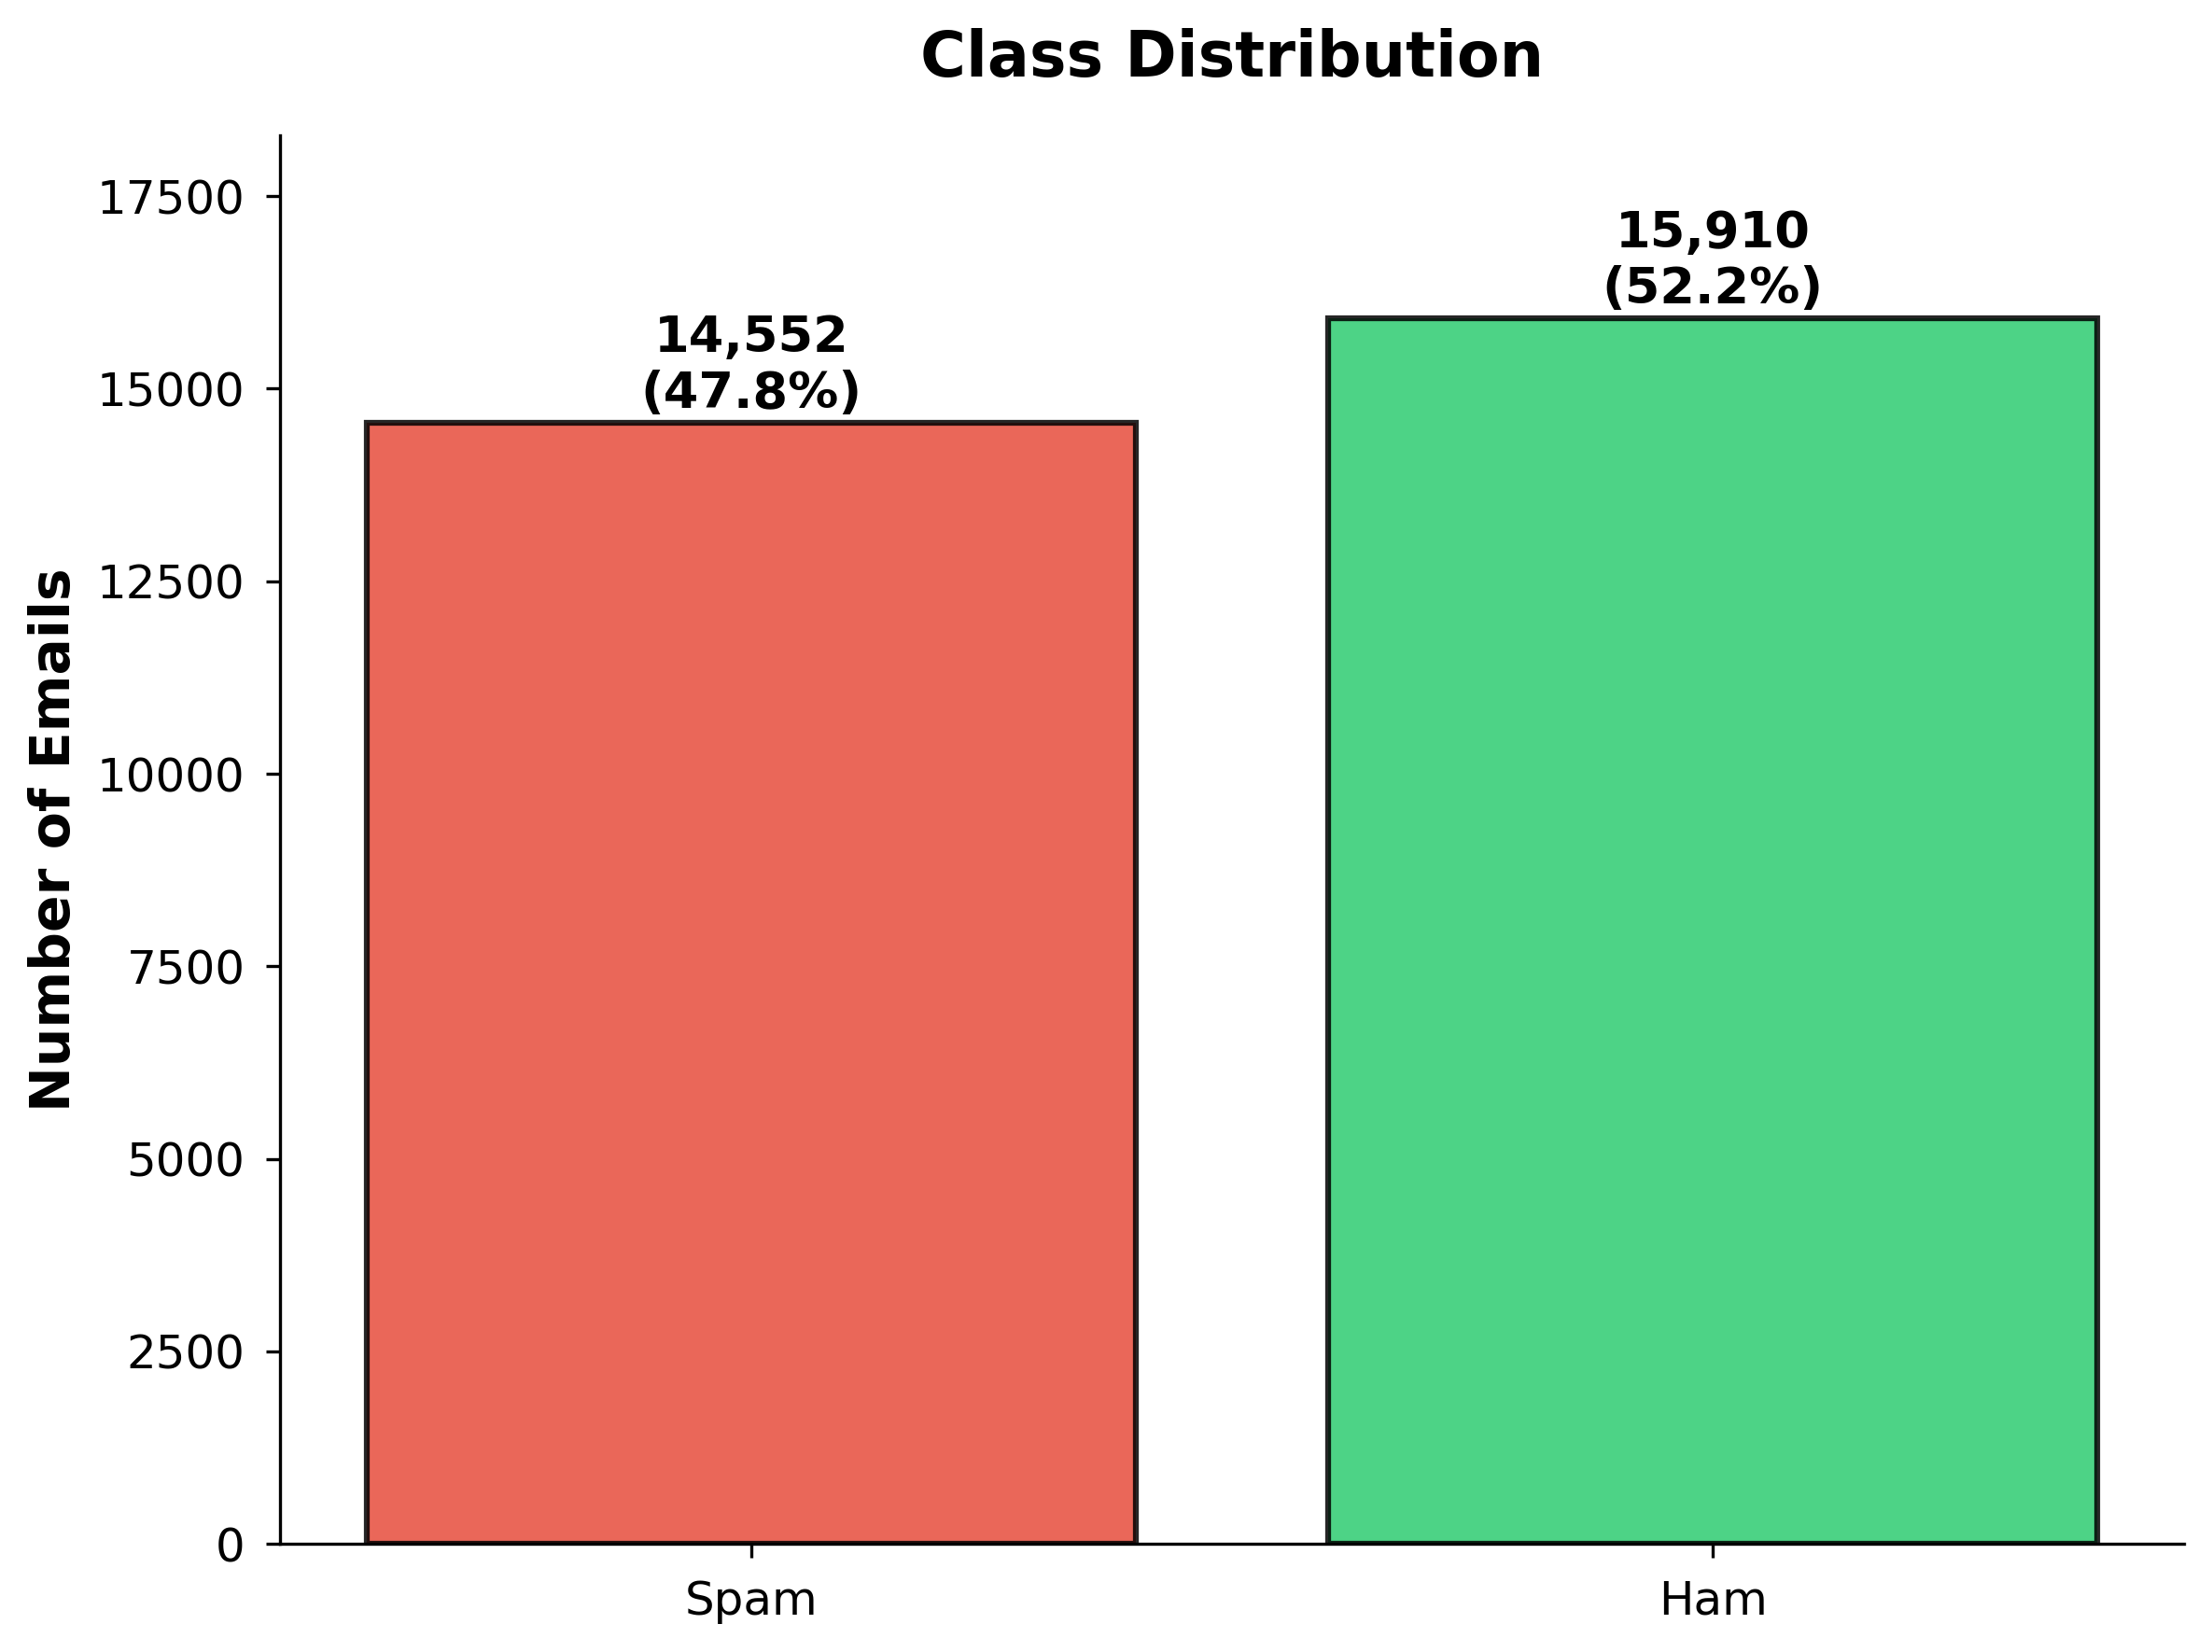


✅ Figure saved to paper_figures/class_distribution.png


In [8]:
# =============================================================================
# CLASS DISTRIBUTION (Deduplicated Dataset)
# =============================================================================
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))

# Hardcoded values
spam_count = 14552
ham_count = 15910
total = 30462

class_counts = [spam_count, ham_count]
class_labels = ['Spam', 'Ham']
colors = ['#e74c3c', '#2ecc71']  # Red and Green

bars = ax.bar(class_labels, class_counts, color=colors, alpha=0.85, edgecolor='black', linewidth=1.5)

ax.set_ylabel('Number of Emails', fontsize=14, fontweight='bold')
ax.set_title('Class Distribution', fontsize=16, fontweight='bold', pad=15)

for bar, count in zip(bars, class_counts):
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 200, 
            f'{count:,}\n({count/total*100:.1f}%)', 
            ha='center', fontweight='bold', fontsize=13)

ax.set_ylim([0, max(class_counts) * 1.15])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', labelsize=12)

plt.tight_layout()
plt.savefig('paper_figures/class_distribution.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig('paper_figures/class_distribution.pdf', bbox_inches='tight')
plt.show()

print("\n✅ Figure saved to paper_figures/class_distribution.png")

## 4️⃣ Load Vectorizers & Saved Results

In [4]:
print("Loading saved components...")

# Load vectorizers (these are definitely fitted)
word_vectorizer = joblib.load(PATHS['word_vectorizer'])
char_vectorizer = joblib.load(PATHS['char_vectorizer'])
print("✅ Vectorizers loaded")

# Load saved results
results_df = pd.read_csv(PATHS['results'])
print("✅ Training results loaded")

# Load ablation results
ablation_df = pd.read_csv(PATHS['ablation_results'])
print("✅ Ablation results loaded")

print(f"\n📊 Results columns: {list(results_df.columns)}")
print(f"📊 Ablation columns: {list(ablation_df.columns)}")

Loading saved components...
✅ Vectorizers loaded
✅ Training results loaded
✅ Ablation results loaded

📊 Results columns: ['split', 'acc', 'f1', 'mcc', 'auprc', 'brier', 'train_time', 'inf_time']
📊 Ablation columns: ['config', 'f1', 'auprc', 'brier']


In [5]:
# Preprocessing function (must match training)
from bs4 import BeautifulSoup
import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

STOP_WORDS = set(stopwords.words('english'))
STEMMER = PorterStemmer()

def preprocess_text(text):
    """Preprocess text matching the training pipeline."""
    if pd.isna(text):
        return ""
    text = unicodedata.normalize('NFC', str(text))
    text = BeautifulSoup(text, 'html.parser').get_text()
    text = re.sub(r'http\S+|www\.\S+', '<URL>', text)
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s<>]', ' ', text)
    tokens = [w for w in text.split() if w and (w == '<url>' or w not in STOP_WORDS)]
    tokens = [STEMMER.stem(w) if w != '<url>' else w for w in tokens]
    return ' '.join(tokens)

print("✅ Preprocessing function defined")

✅ Preprocessing function defined


In [6]:
# Prepare data
print("Preparing data...")

X_train_text, X_test_text, y_train, y_test = train_test_split(
    df['text'].values,
    df['label'].values,
    test_size=CONFIG['TEST_SIZE'],
    stratify=df['label'].values,
    random_state=CONFIG['RANDOM_STATE']
)

# Preprocess
X_train_processed = [preprocess_text(text) for text in X_train_text]
X_test_processed = [preprocess_text(text) for text in X_test_text]

# Extract features using LOADED (already fitted) vectorizers - just transform!
X_word_train = word_vectorizer.transform(X_train_processed)
X_word_test = word_vectorizer.transform(X_test_processed)
X_char_train = char_vectorizer.transform(X_train_processed)
X_char_test = char_vectorizer.transform(X_test_processed)

def extract_numeric_features(processed_texts):
    msg_lengths = np.array([len(text.split()) for text in processed_texts])
    log_msg_length = np.log1p(msg_lengths).reshape(-1, 1)
    url_counts = np.array([text.count('<url>') for text in processed_texts]).reshape(-1, 1)
    return sp.csr_matrix(np.hstack([log_msg_length, url_counts]))

X_numeric_train = extract_numeric_features(X_train_processed)
X_numeric_test = extract_numeric_features(X_test_processed)

X_train_combined = sp.hstack([X_word_train, X_char_train, X_numeric_train])
X_test_combined = sp.hstack([X_word_test, X_char_test, X_numeric_test])

print(f"✅ Features ready: {X_test_combined.shape}")

Preparing data...
✅ Features ready: (6733, 38002)


## 5️⃣ Build & Fit Ensemble

The saved ensemble pickle may not be fitted properly. We rebuild it here using the same config.

In [7]:
print("Building and fitting ensemble...")
print("(Vectorizers are pre-fitted, so this is fast)\n")

# Build ensemble with same architecture as training
svm_calibrated = CalibratedClassifierCV(
    LinearSVC(C=CONFIG['SVM_C'], random_state=CONFIG['RANDOM_STATE'], max_iter=2000),
    method='sigmoid',
    cv=CONFIG['CALIBRATION_CV']
)

nb = ComplementNB(alpha=CONFIG['NB_ALPHA'])

gb = GradientBoostingClassifier(
    n_estimators=CONFIG['GB_N_ESTIMATORS'],
    learning_rate=CONFIG['GB_LEARNING_RATE'],
    max_depth=CONFIG['GB_MAX_DEPTH'],
    subsample=CONFIG['GB_SUBSAMPLE'],
    random_state=CONFIG['RANDOM_STATE']
)

ensemble = VotingClassifier(
    estimators=[
        ('svm', svm_calibrated),
        ('nb', nb),
        ('gb', gb)
    ],
    voting='soft',
    weights=CONFIG['ENSEMBLE_WEIGHTS']
)

# Fit the ensemble
print("Fitting ensemble (this takes ~2-3 minutes)...")
start_time = time.time()
ensemble.fit(X_train_combined, y_train)
train_time = time.time() - start_time
print(f"✅ Ensemble fitted in {train_time:.1f} seconds")

Building and fitting ensemble...
(Vectorizers are pre-fitted, so this is fast)

Fitting ensemble (this takes ~2-3 minutes)...
✅ Ensemble fitted in 930.3 seconds


In [8]:
# Generate predictions
print("Generating predictions...")

start_time = time.time()
y_pred = ensemble.predict(X_test_combined)
y_proba = ensemble.predict_proba(X_test_combined)[:, 1]
inference_time = time.time() - start_time
latency_per_sample_ms = (inference_time / len(X_test_text)) * 1000

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average='macro')
mcc = matthews_corrcoef(y_test, y_pred)
auprc = average_precision_score(y_test, y_proba)
brier = brier_score_loss(y_test, y_proba)

spam_scores = y_proba[y_test == 1]
ham_scores = y_proba[y_test == 0]
ks_stat = scipy_stats.ks_2samp(spam_scores, ham_scores)[0]

print(f"\n✅ Metrics on this split:")
print(f"   Accuracy: {accuracy:.4f}")
print(f"   Macro-F1: {macro_f1:.4f}")
print(f"   AUPRC:    {auprc:.4f}")
print(f"   Latency:  {latency_per_sample_ms:.2f} ms/sample")

Generating predictions...

✅ Metrics on this split:
   Accuracy: 0.9930
   Macro-F1: 0.9930
   AUPRC:    0.9994
   Latency:  0.07 ms/sample


---
# 📊 TABLES & FIGURES
---

## 📊 Table 1 & Figure 1: Dataset Overview

In [9]:
spam_df = df[df['label'] == 1]
ham_df = df[df['label'] == 0]

table1 = pd.DataFrame({
    'Statistic': ['Documents', 'Mean body length (tokens)', 'Std. dev. (tokens)'],
    'Spam': [
        f"{len(spam_df):,}",
        f"{spam_df['msg_length'].mean():.0f}",
        f"{spam_df['msg_length'].std():.0f}"
    ],
    'Ham': [
        f"{len(ham_df):,}",
        f"{ham_df['msg_length'].mean():.0f}",
        f"{ham_df['msg_length'].std():.0f}"
    ]
})

print("\n" + "="*60)
print("TABLE 1: Corpus Statistics")
print("="*60)
print(table1.to_string(index=False))
print("="*60)

table1.to_csv('paper_figures/table1_corpus_stats.csv', index=False)
print("\n✅ Table 1 saved")


TABLE 1: Corpus Statistics
                Statistic   Spam    Ham
                Documents 17,120 16,545
Mean body length (tokens)    262    362
       Std. dev. (tokens)    387   1148

✅ Table 1 saved


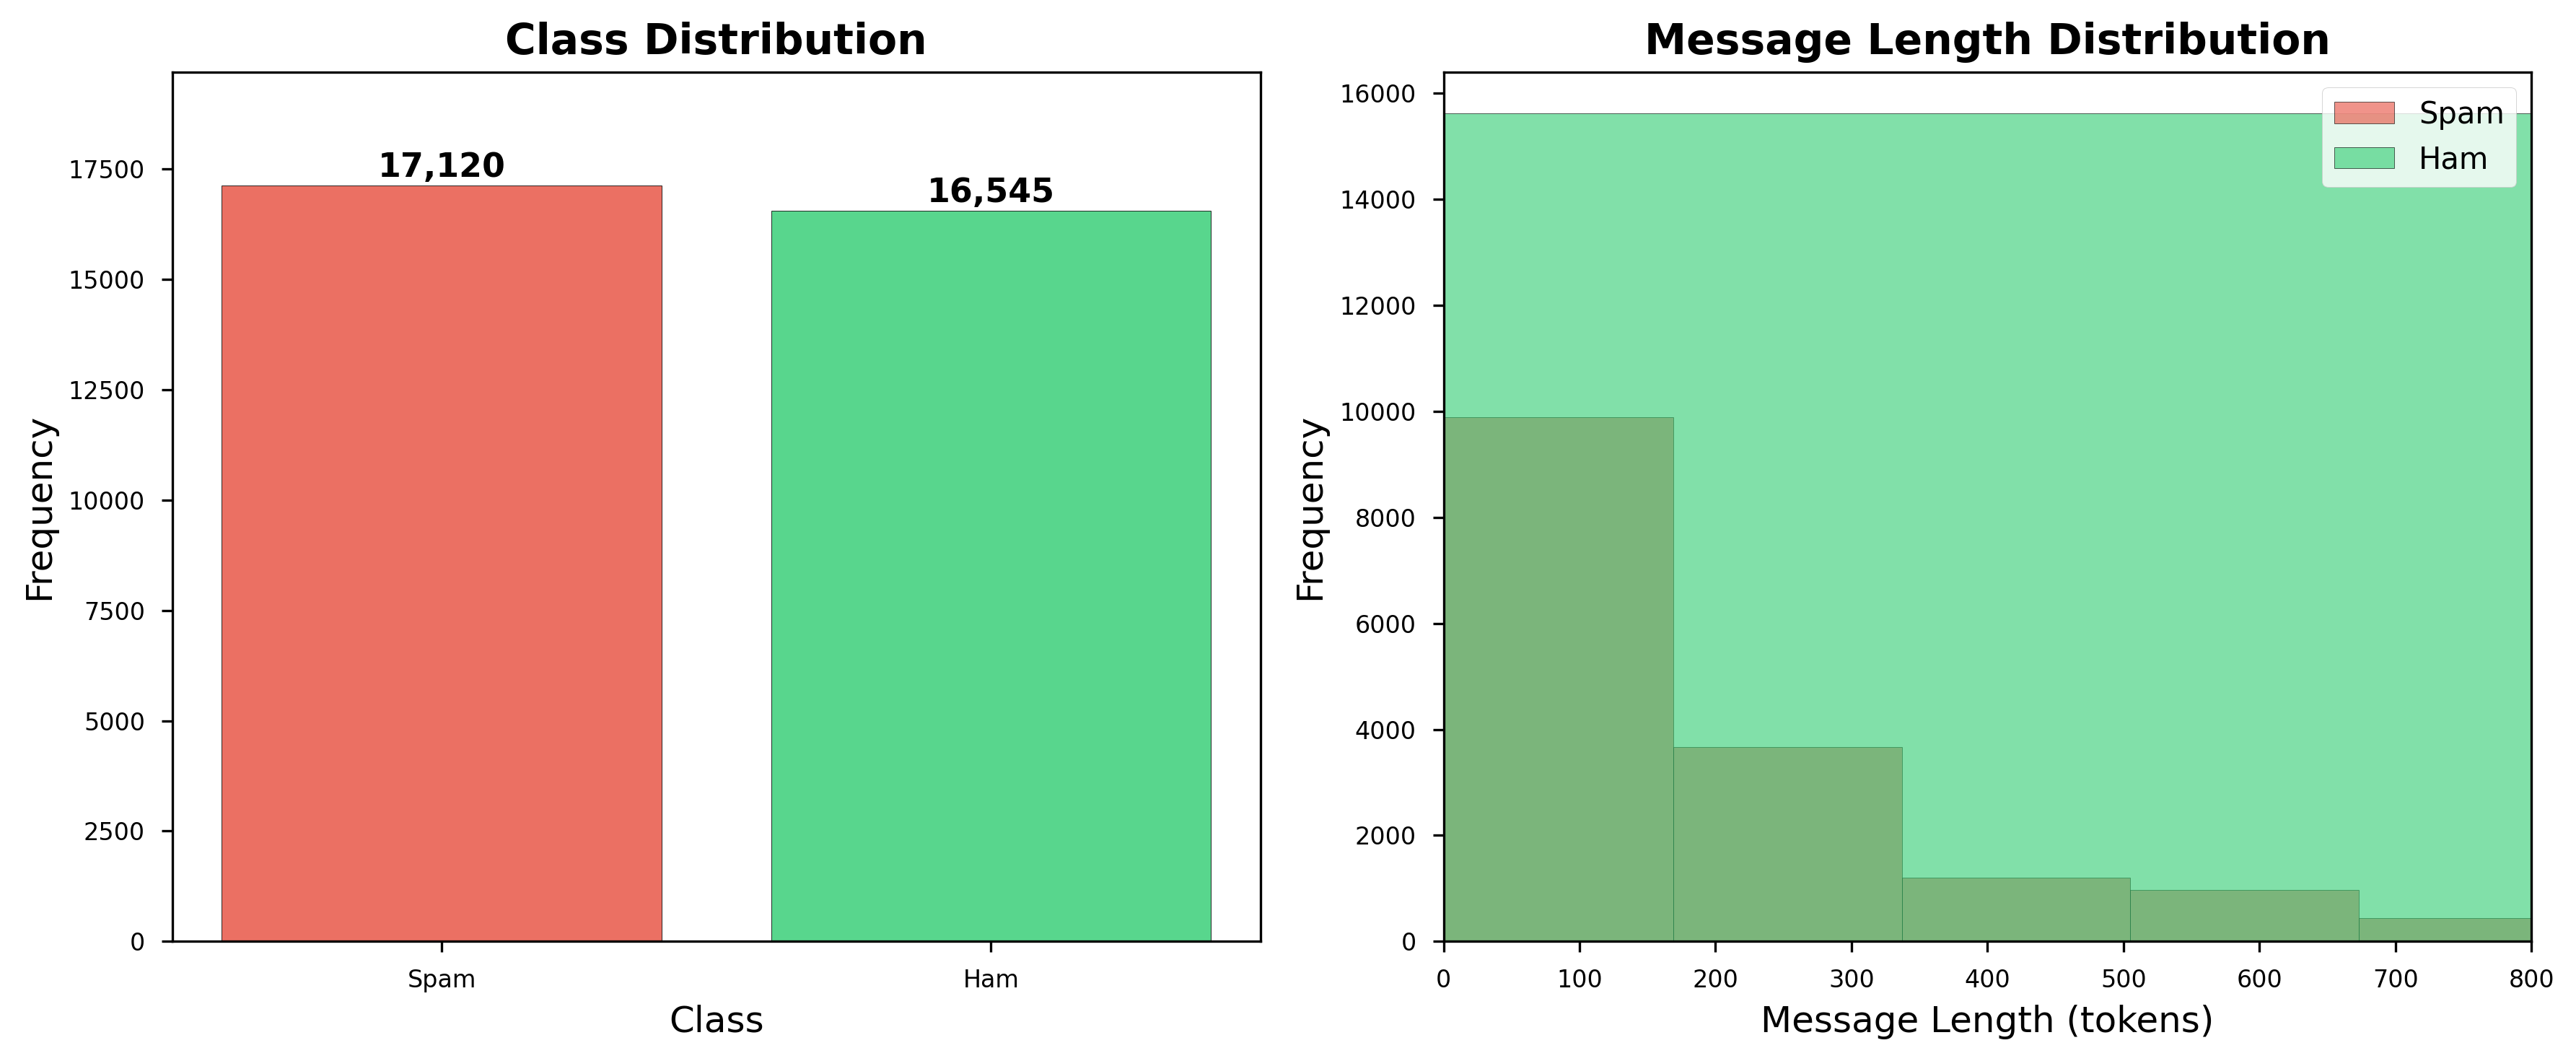

✅ Figure 1 saved


In [10]:
# Figure 1: Dataset visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ham_count = len(ham_df)
spam_count = len(spam_df)

bars = axes[0].bar(['Spam', 'Ham'], [spam_count, ham_count], 
                   color=['#e74c3c', '#2ecc71'], alpha=0.8, edgecolor='black')
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_xlabel('Class', fontsize=12)
axes[0].set_title('Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_ylim(0, max(ham_count, spam_count) * 1.15)

for bar in bars:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 200,
                 f'{int(height):,}', ha='center', fontweight='bold', fontsize=11)

axes[1].hist(spam_df['msg_length'], bins=50, alpha=0.6, label='Spam', 
             color='#e74c3c', edgecolor='black')
axes[1].hist(ham_df['msg_length'], bins=50, alpha=0.6, label='Ham', 
             color='#2ecc71', edgecolor='black')
axes[1].set_xlabel('Message Length (tokens)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Message Length Distribution', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].set_xlim(0, 800)

plt.tight_layout()
plt.savefig('paper_figures/figure1_dataset_overview.png', dpi=300, bbox_inches='tight')
plt.savefig('paper_figures/figure1_dataset_overview.pdf', bbox_inches='tight')
plt.show()

print("✅ Figure 1 saved")

## 📊 Table 2 & Figure 2: Calibration Comparison

In [11]:
print("Training calibration comparison models...\n")

# Use a subset for calibration demo
X_train_calib, X_val_calib, y_train_calib, y_val_calib = train_test_split(
    X_word_train, y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=CONFIG['RANDOM_STATE']
)

print("  [1/3] Uncalibrated SVM...")
svm_uncal = LinearSVC(C=CONFIG['SVM_C'], random_state=CONFIG['RANDOM_STATE'], max_iter=2000)
svm_uncal.fit(X_train_calib, y_train_calib)
uncal_decision = svm_uncal.decision_function(X_val_calib)
uncal_proba = expit(uncal_decision)

print("  [2/3] Platt Sigmoid calibration...")
svm_platt = CalibratedClassifierCV(
    LinearSVC(C=CONFIG['SVM_C'], random_state=CONFIG['RANDOM_STATE'], max_iter=2000),
    method='sigmoid', cv=CONFIG['CALIBRATION_CV']
)
svm_platt.fit(X_train_calib, y_train_calib)
platt_proba = svm_platt.predict_proba(X_val_calib)[:, 1]

print("  [3/3] Isotonic Regression calibration...")
svm_isotonic = CalibratedClassifierCV(
    LinearSVC(C=CONFIG['SVM_C'], random_state=CONFIG['RANDOM_STATE'], max_iter=2000),
    method='isotonic', cv=CONFIG['CALIBRATION_CV']
)
svm_isotonic.fit(X_train_calib, y_train_calib)
isotonic_proba = svm_isotonic.predict_proba(X_val_calib)[:, 1]

print("✅ Calibration models trained")

Training calibration comparison models...

  [1/3] Uncalibrated SVM...
  [2/3] Platt Sigmoid calibration...
  [3/3] Isotonic Regression calibration...
✅ Calibration models trained


In [12]:
# Calculate calibration metrics
uncal_brier = brier_score_loss(y_val_calib, uncal_proba)
platt_brier = brier_score_loss(y_val_calib, platt_proba)
isotonic_brier = brier_score_loss(y_val_calib, isotonic_proba)

uncal_logloss = log_loss(y_val_calib, np.column_stack([1-uncal_proba, uncal_proba]))
platt_logloss = log_loss(y_val_calib, svm_platt.predict_proba(X_val_calib))
isotonic_logloss = log_loss(y_val_calib, svm_isotonic.predict_proba(X_val_calib))

table2 = pd.DataFrame({
    'Method': ['Uncalibrated SVM margins', 'Platt sigmoid', 'Isotonic regression'],
    'Brier ↓': [f'{uncal_brier:.3f}', f'{platt_brier:.3f}', f'{isotonic_brier:.3f}'],
    'Log-loss ↓': [f'{uncal_logloss:.2f}', f'{platt_logloss:.3f}', f'{isotonic_logloss:.3f}']
})

print("\n" + "="*60)
print("TABLE 2: Calibration Method Comparison")
print("="*60)
print(table2.to_string(index=False))
print("="*60)

table2.to_csv('paper_figures/table2_calibration.csv', index=False)
print("\n✅ Table 2 saved")


TABLE 2: Calibration Method Comparison
                  Method Brier ↓ Log-loss ↓
Uncalibrated SVM margins   0.047       0.22
           Platt sigmoid   0.009      0.034
     Isotonic regression   0.009      0.034

✅ Table 2 saved


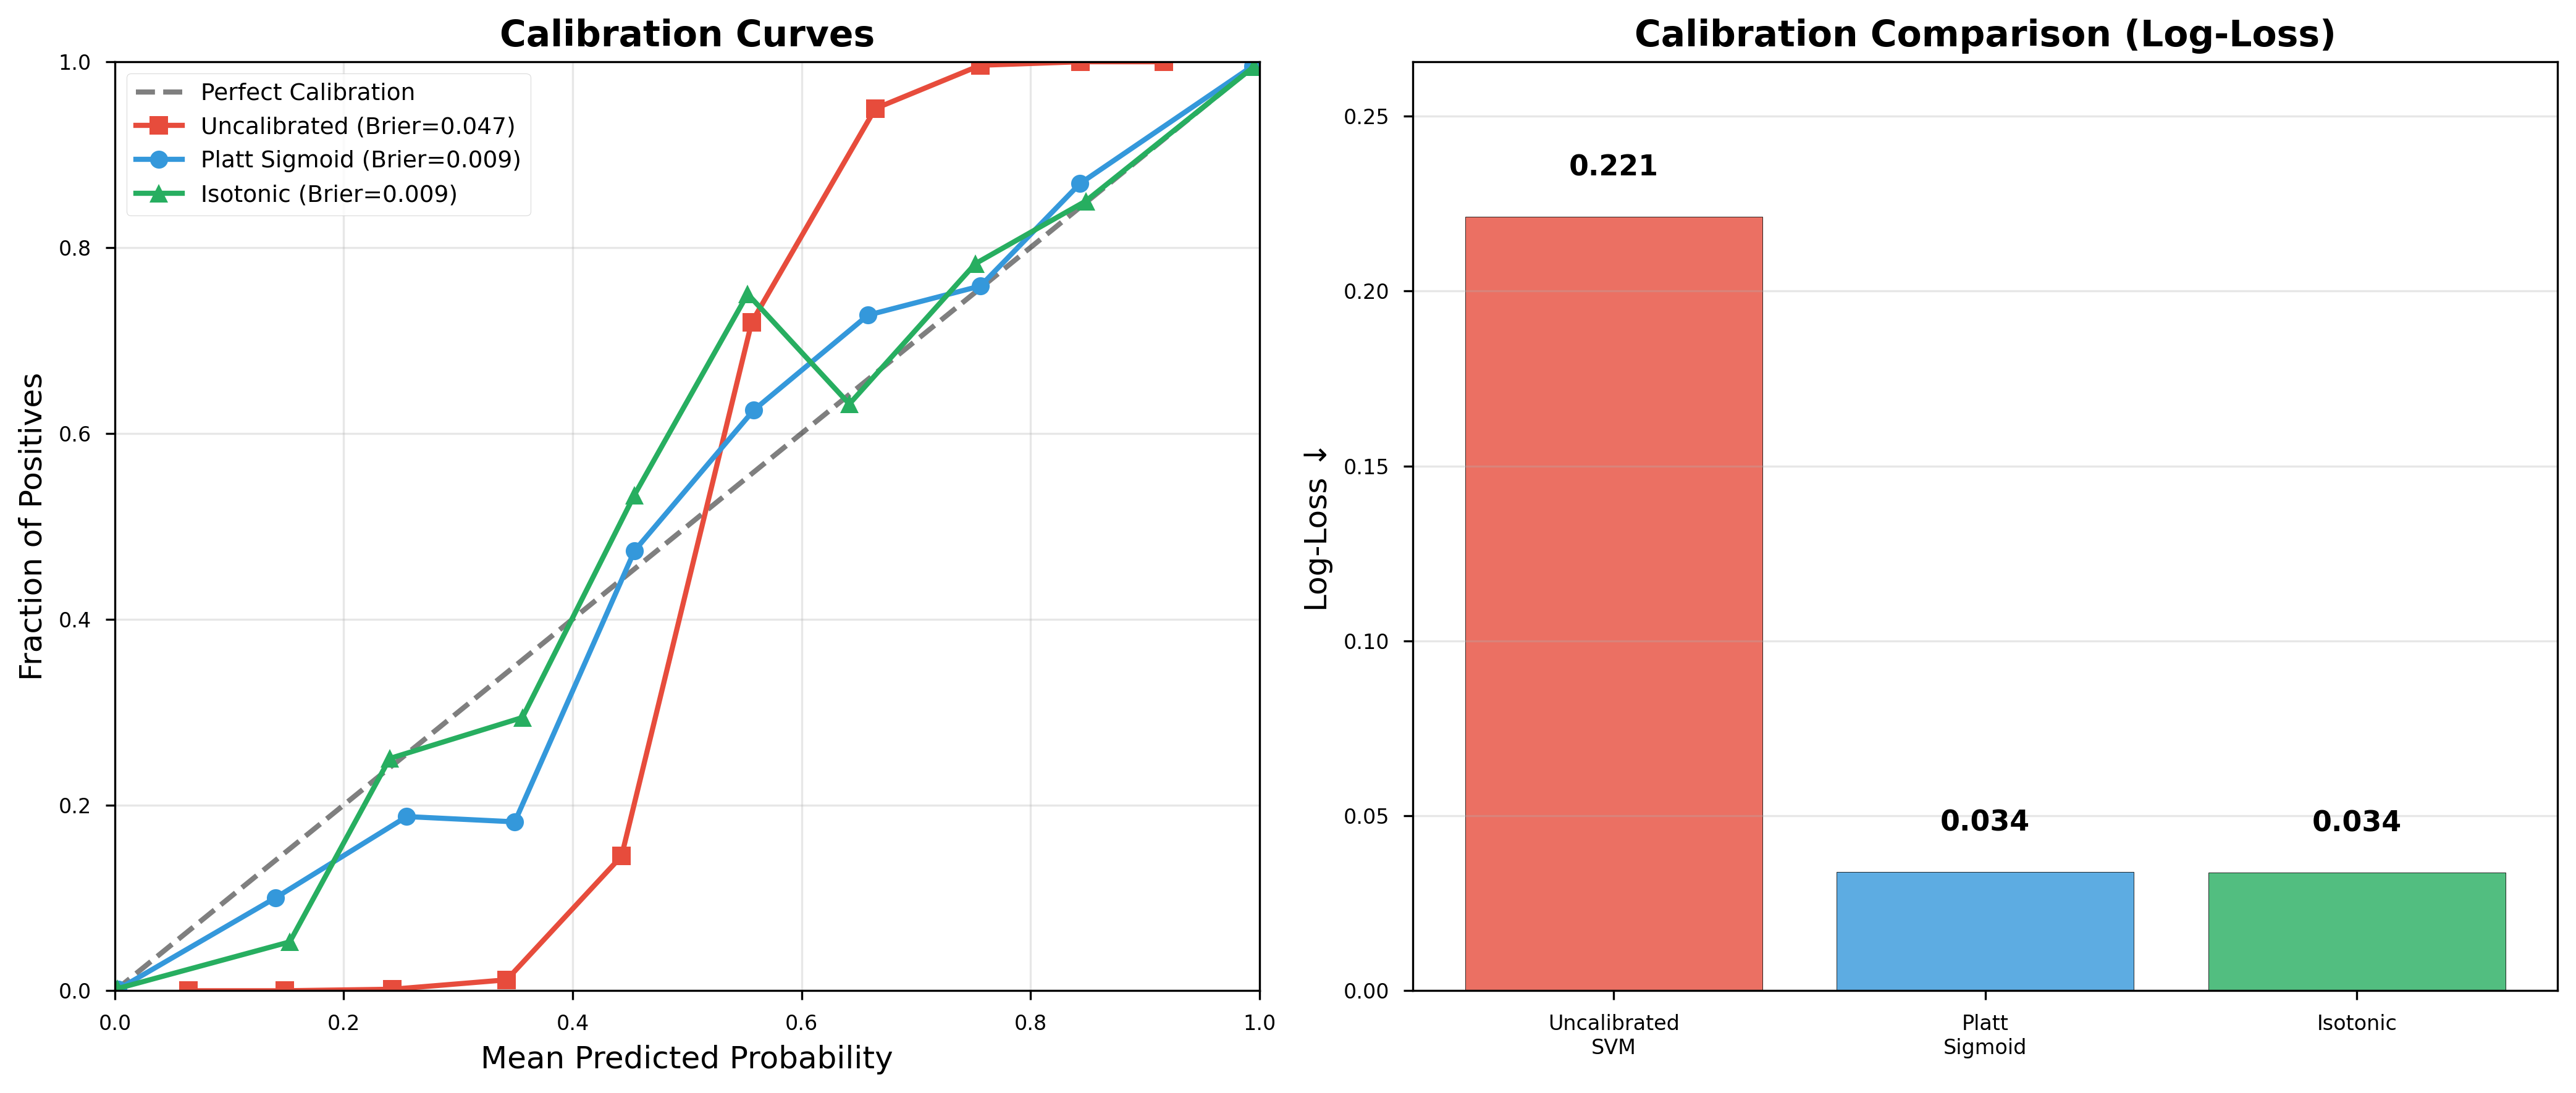

✅ Figure 2 saved


In [13]:
# Figure 2: Calibration comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: Calibration curves
axes[0].plot([0, 1], [0, 1], 'k--', label='Perfect Calibration', linewidth=2, alpha=0.5)

prob_true_uncal, prob_pred_uncal = calibration_curve(y_val_calib, uncal_proba, n_bins=10)
axes[0].plot(prob_pred_uncal, prob_true_uncal, 's-', 
            label=f'Uncalibrated (Brier={uncal_brier:.3f})',
            linewidth=2, markersize=7, color='#e74c3c')

prob_true_platt, prob_pred_platt = calibration_curve(y_val_calib, platt_proba, n_bins=10)
axes[0].plot(prob_pred_platt, prob_true_platt, 'o-',
            label=f'Platt Sigmoid (Brier={platt_brier:.3f})',
            linewidth=2, markersize=7, color='#3498db')

prob_true_iso, prob_pred_iso = calibration_curve(y_val_calib, isotonic_proba, n_bins=10)
axes[0].plot(prob_pred_iso, prob_true_iso, '^-',
            label=f'Isotonic (Brier={isotonic_brier:.3f})',
            linewidth=2, markersize=7, color='#27ae60')

axes[0].set_xlabel('Mean Predicted Probability', fontsize=12)
axes[0].set_ylabel('Fraction of Positives', fontsize=12)
axes[0].set_title('Calibration Curves', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=9, loc='upper left')
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])

# Right: Log-loss bar chart
methods = ['Uncalibrated\nSVM', 'Platt\nSigmoid', 'Isotonic']
logloss_values = [uncal_logloss, platt_logloss, isotonic_logloss]
colors = ['#e74c3c', '#3498db', '#27ae60']

bars = axes[1].bar(methods, logloss_values, color=colors, alpha=0.8, edgecolor='black')
for bar, val in zip(bars, logloss_values):
    axes[1].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
                 f'{val:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

axes[1].set_ylabel('Log-Loss ↓', fontsize=12)
axes[1].set_title('Calibration Comparison (Log-Loss)', fontsize=14, fontweight='bold')
axes[1].set_ylim([0, max(logloss_values) * 1.2])
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('paper_figures/figure2_calibration.png', dpi=300, bbox_inches='tight')
plt.savefig('paper_figures/figure2_calibration.pdf', bbox_inches='tight')
plt.show()

print("✅ Figure 2 saved")

## 📊 Table 3: Performance Metrics (from saved CV results)

In [14]:
print("Loading metrics from saved results...")
print(f"\nAvailable columns: {list(results_df.columns)}")
print(f"\nResults preview:")
print(results_df.head())

Loading metrics from saved results...

Available columns: ['split', 'acc', 'f1', 'mcc', 'auprc', 'brier', 'train_time', 'inf_time']

Results preview:
   split       acc        f1       mcc     auprc     brier   train_time  \
0      0  0.988672  0.988653  0.977339  0.998542  0.013239  1367.442141   
1      1  0.988836  0.988818  0.977678  0.998723  0.013788  1375.010689   
2      2  0.989985  0.989969  0.979983  0.998735  0.012380  1392.185415   
3      3  0.988672  0.988654  0.977374  0.998831  0.013055  1375.235421   
4      4  0.988343  0.988325  0.976694  0.998470  0.013334  1373.224656   

    inf_time  
0  14.818685  
1  17.496469  
2  15.900981  
3  15.251858  
4  20.973938  


In [15]:
# Map column names (handles different naming conventions)
col_mapping = {
    'accuracy': ['accuracy', 'Accuracy', 'acc'],
    'macro_f1': ['macro_f1', 'Macro-F1', 'f1_macro', 'macro_F1', 'f1', 'F1'],
    'mcc': ['mcc', 'MCC', 'matthews_corrcoef'],
    'auprc': ['auprc', 'AUPRC', 'average_precision', 'pr_auc', 'AP'],
    'ks_stat': ['ks_stat', 'KS-stat', 'ks', 'ks_statistic', 'KS']
}

def find_col(df, names):
    for name in names:
        if name in df.columns:
            return name
    return None

# Extract metrics from saved results
metrics_from_cv = {}
for metric, possible_names in col_mapping.items():
    col = find_col(results_df, possible_names)
    if col:
        metrics_from_cv[metric] = results_df[col].mean()

# Build Table 3 - use CV results if available, otherwise current split
table3_data = [
    ['Accuracy', f"{metrics_from_cv.get('accuracy', accuracy):.4f}"],
    ['Macro-F1', f"{metrics_from_cv.get('macro_f1', macro_f1):.4f}"],
    ['MCC', f"{metrics_from_cv.get('mcc', mcc):.4f}"],
    ['AUPRC', f"{metrics_from_cv.get('auprc', auprc):.4f}"],
    ['KS-stat', f"{metrics_from_cv.get('ks_stat', ks_stat):.4f}"],
]

table3 = pd.DataFrame(table3_data, columns=['Metric', 'Value'])

print("\n" + "="*60)
print("TABLE 3: Performance Metrics")
print("="*60)
print(table3.to_string(index=False))
print("="*60)

table3.to_csv('paper_figures/table3_performance.csv', index=False)
print("\n✅ Table 3 saved")


TABLE 3: Performance Metrics
  Metric  Value
Accuracy 0.9892
Macro-F1 0.9892
     MCC 0.9784
   AUPRC 0.9986
 KS-stat 0.9889

✅ Table 3 saved


## 📊 Table 4 & Figure 3: Ablation Study (from saved results)

In [16]:
print("Ablation results:")
print(ablation_df.to_string())

Ablation results:
                config        f1     auprc     brier
0      Word-only + SVM  0.987829  0.998486  0.009289
1      Char-only + SVM  0.989146  0.999109  0.008376
2   Dual-channel + SVM  0.990625  0.999195  0.007534
3    Ensemble (no cal)  0.987504  0.999022  0.027482
4  Calibrated Ensemble  0.990954  0.998469  0.009042


In [17]:
# Format and display Table 4
table4 = ablation_df.copy()

# Format numeric columns
for col in table4.columns:
    if table4[col].dtype in ['float64', 'float32']:
        table4[col] = table4[col].apply(lambda x: f"{x:.4f}")

print("\n" + "="*70)
print("TABLE 4: Ablation Study")
print("="*70)
print(table4.to_string(index=False))
print("="*70)

table4.to_csv('paper_figures/table4_ablation.csv', index=False)
print("\n✅ Table 4 saved")


TABLE 4: Ablation Study
             config     f1  auprc  brier
    Word-only + SVM 0.9878 0.9985 0.0093
    Char-only + SVM 0.9891 0.9991 0.0084
 Dual-channel + SVM 0.9906 0.9992 0.0075
  Ensemble (no cal) 0.9875 0.9990 0.0275
Calibrated Ensemble 0.9910 0.9985 0.0090

✅ Table 4 saved


Using: variant='config', f1='f1'


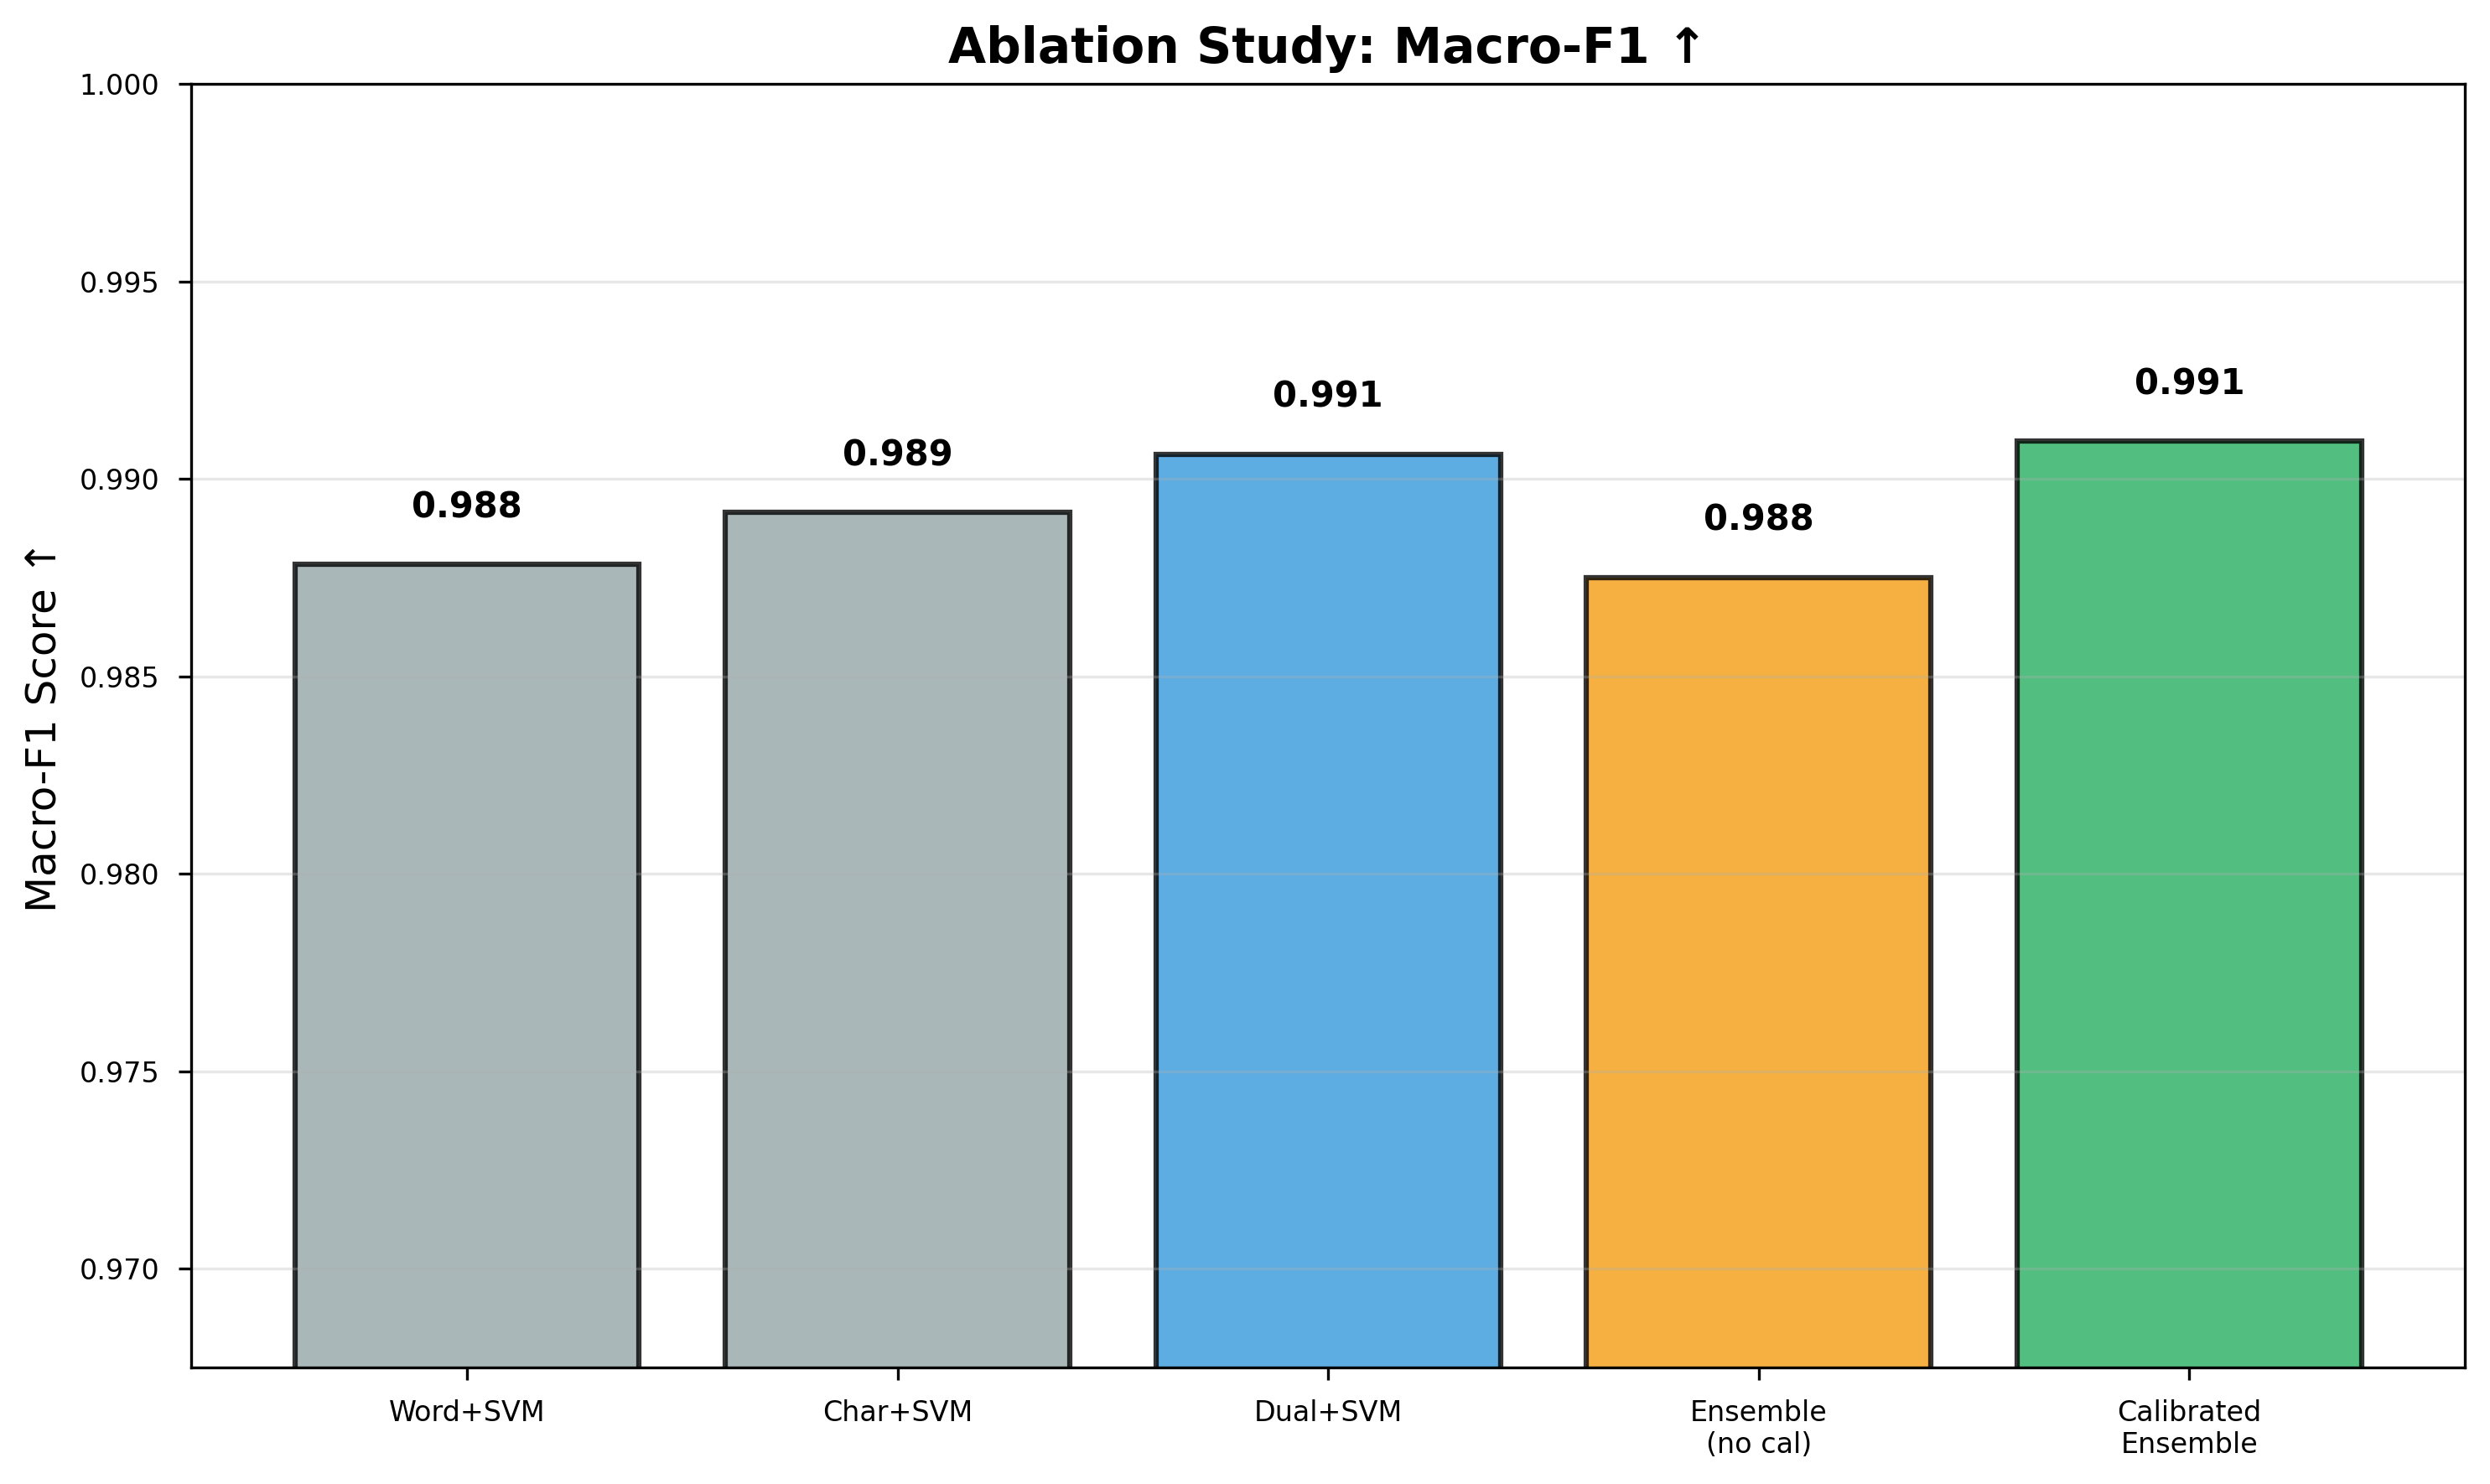

✅ Figure 3 saved


In [18]:
# Figure 3: Ablation bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Find variant and F1 columns
variant_col = ablation_df.columns[0]  # First column is usually variant name
f1_col = None
for col in ablation_df.columns:
    if 'f1' in col.lower() or 'macro' in col.lower():
        f1_col = col
        break
if f1_col is None:
    f1_col = ablation_df.columns[1]  # Fallback to second column

print(f"Using: variant='{variant_col}', f1='{f1_col}'")

variants = ablation_df[variant_col].tolist()
f1_scores = ablation_df[f1_col].astype(float).tolist()

# Shorten names for display
short_names = []
for v in variants:
    v_lower = str(v).lower()
    if 'word' in v_lower and 'only' in v_lower:
        short_names.append('Word+SVM')
    elif 'char' in v_lower and 'only' in v_lower:
        short_names.append('Char+SVM')
    elif 'dual' in v_lower:
        short_names.append('Dual+SVM')
    elif 'no cal' in v_lower or 'uncal' in v_lower or 'without' in v_lower:
        short_names.append('Ensemble\n(no cal)')
    elif 'calibrat' in v_lower or 'full' in v_lower:
        short_names.append('Calibrated\nEnsemble')
    else:
        short_names.append(str(v)[:12])

colors = ['#95a5a6', '#95a5a6', '#3498db', '#f39c12', '#27ae60'][:len(variants)]

bars = ax.bar(short_names, f1_scores, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

for bar, score in zip(bars, f1_scores):
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.001,
            f'{score:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

ax.set_ylabel('Macro-F1 Score ↑', fontsize=12)
ax.set_title('Ablation Study: Macro-F1 ↑', fontsize=14, fontweight='bold')
ax.set_ylim([min(f1_scores) - 0.02, 1.0])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('paper_figures/figure3_ablation.png', dpi=300, bbox_inches='tight')
plt.savefig('paper_figures/figure3_ablation.pdf', bbox_inches='tight')
plt.show()

print("✅ Figure 3 saved")

## 📊 Additional: Confusion Matrix

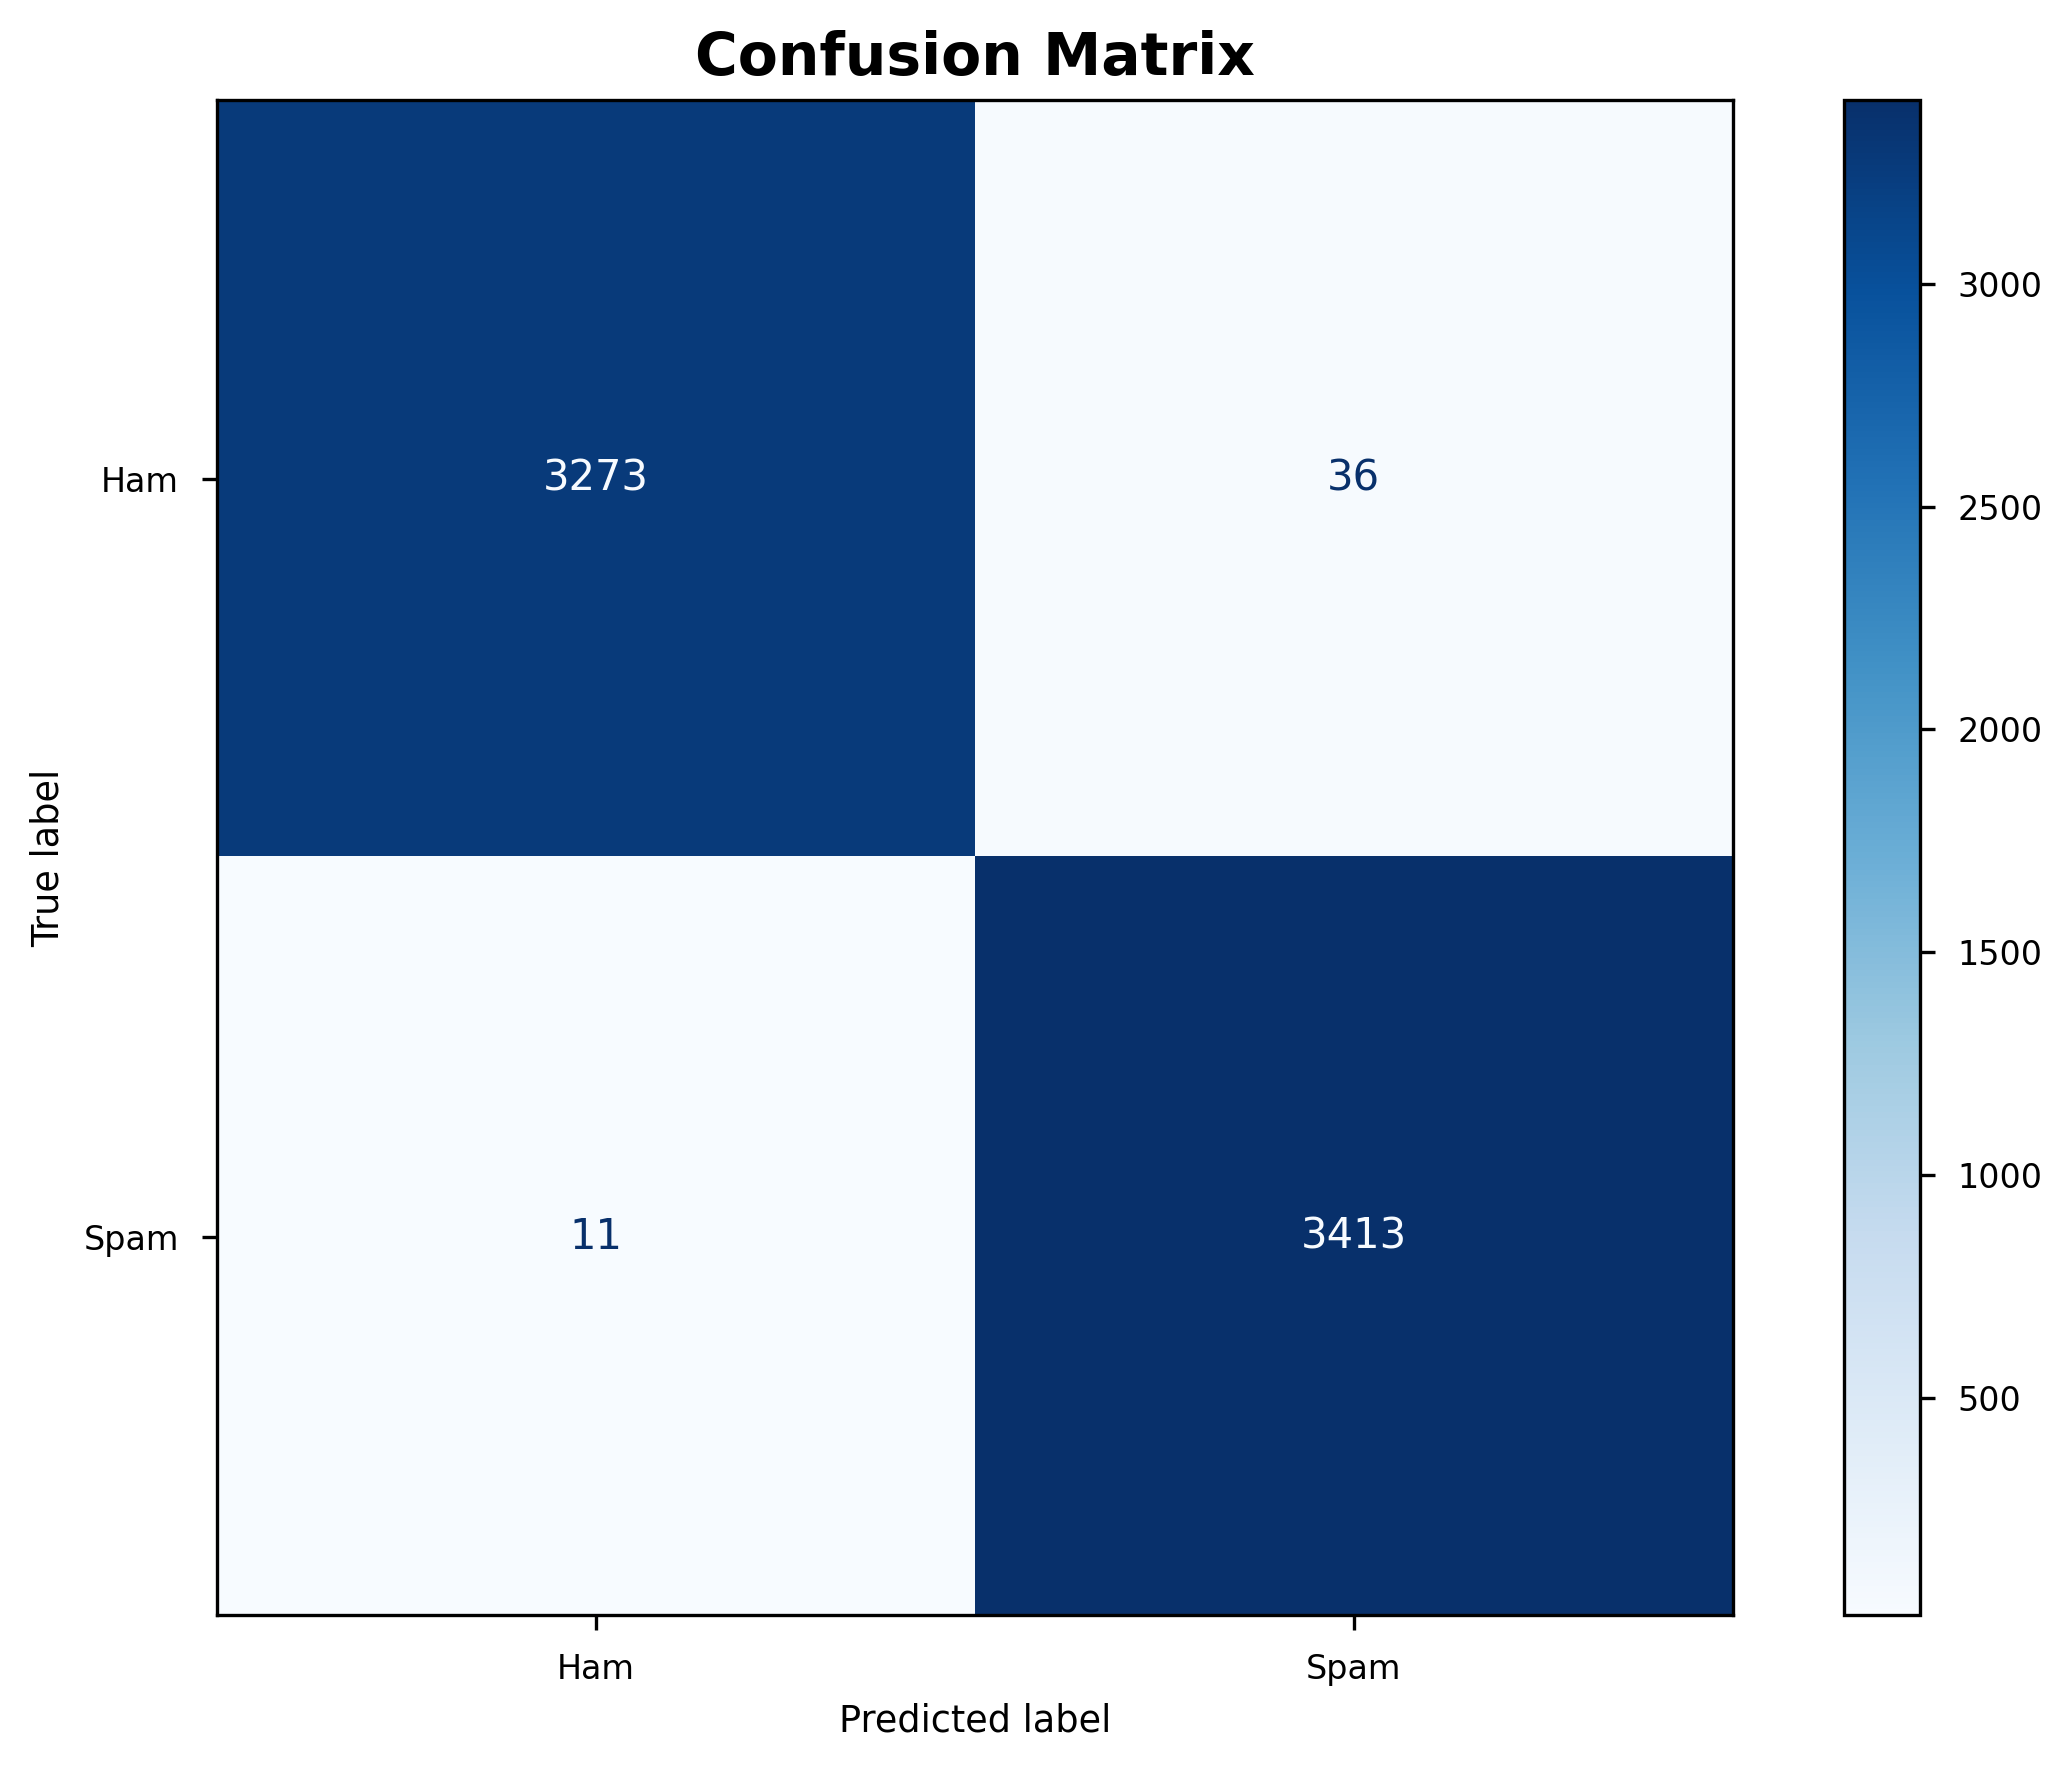

✅ Confusion matrix saved

Classification Report:
              precision    recall  f1-score   support

         Ham       1.00      0.99      0.99      3309
        Spam       0.99      1.00      0.99      3424

    accuracy                           0.99      6733
   macro avg       0.99      0.99      0.99      6733
weighted avg       0.99      0.99      0.99      6733



In [19]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(8, 6))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ham', 'Spam'])
disp.plot(ax=ax, cmap='Blues', values_format='d')

ax.set_title('Confusion Matrix', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('paper_figures/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.savefig('paper_figures/confusion_matrix.pdf', bbox_inches='tight')
plt.show()

print("✅ Confusion matrix saved")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))

## 📊 Additional: ROC & PR Curves

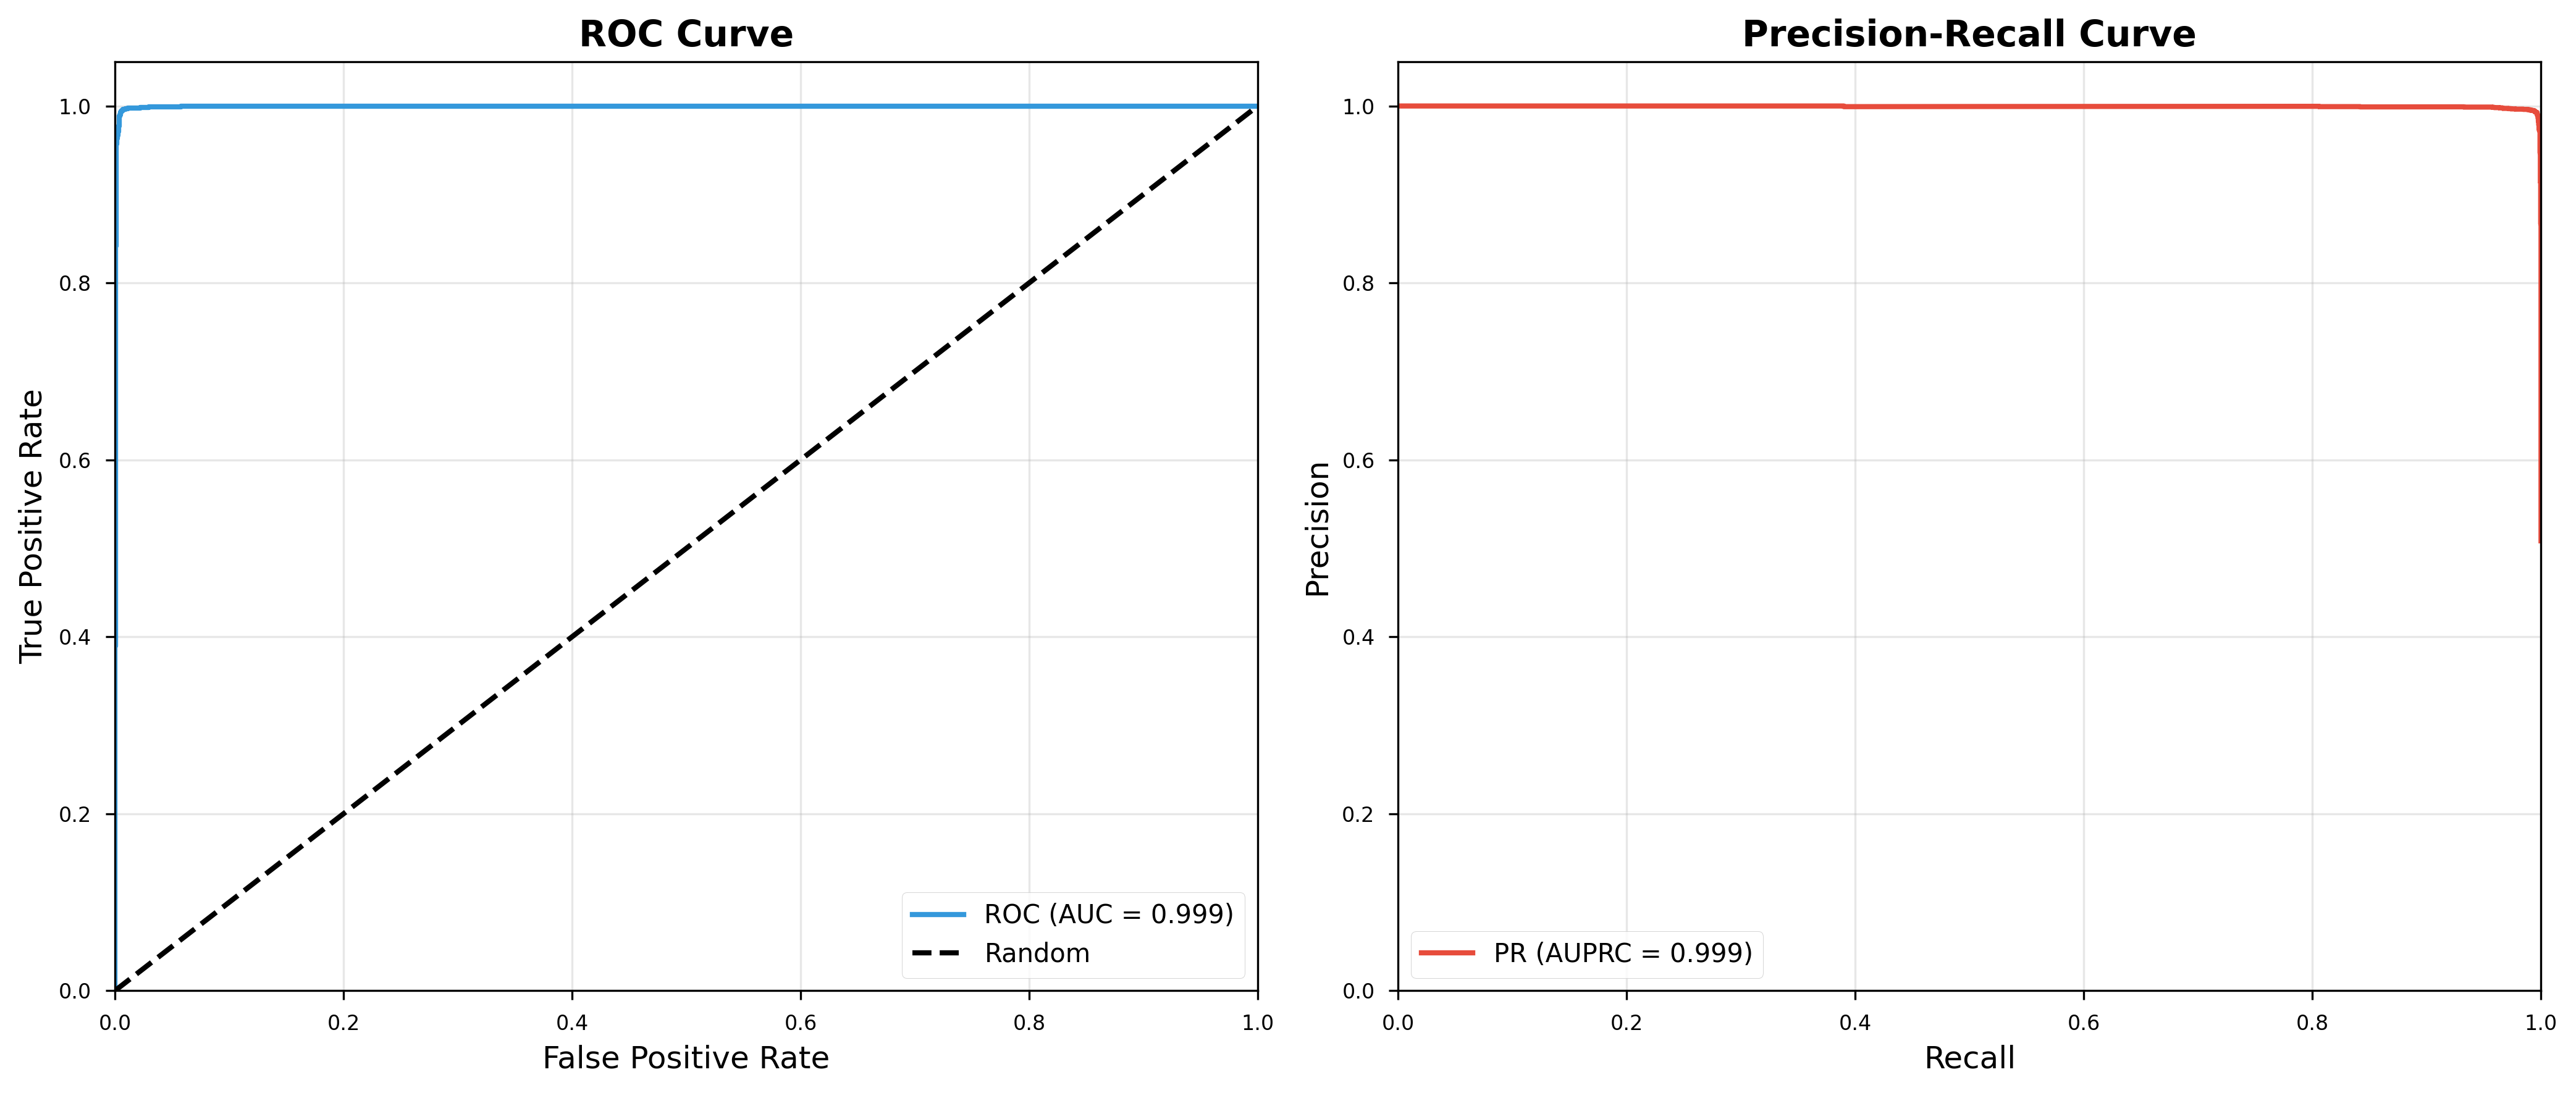

✅ ROC & PR curves saved


In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

axes[0].plot(fpr, tpr, color='#3498db', lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
axes[0].plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[0].legend(loc='lower right', fontsize=10)
axes[0].grid(alpha=0.3)

# PR Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)

axes[1].plot(recall, precision, color='#e74c3c', lw=2, label=f'PR (AUPRC = {auprc:.3f})')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower left', fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('paper_figures/roc_pr_curves.png', dpi=300, bbox_inches='tight')
plt.savefig('paper_figures/roc_pr_curves.pdf', bbox_inches='tight')
plt.show()

print("✅ ROC & PR curves saved")

## 📊 Additional: Feature Importance

Extracting feature importance from SVM...


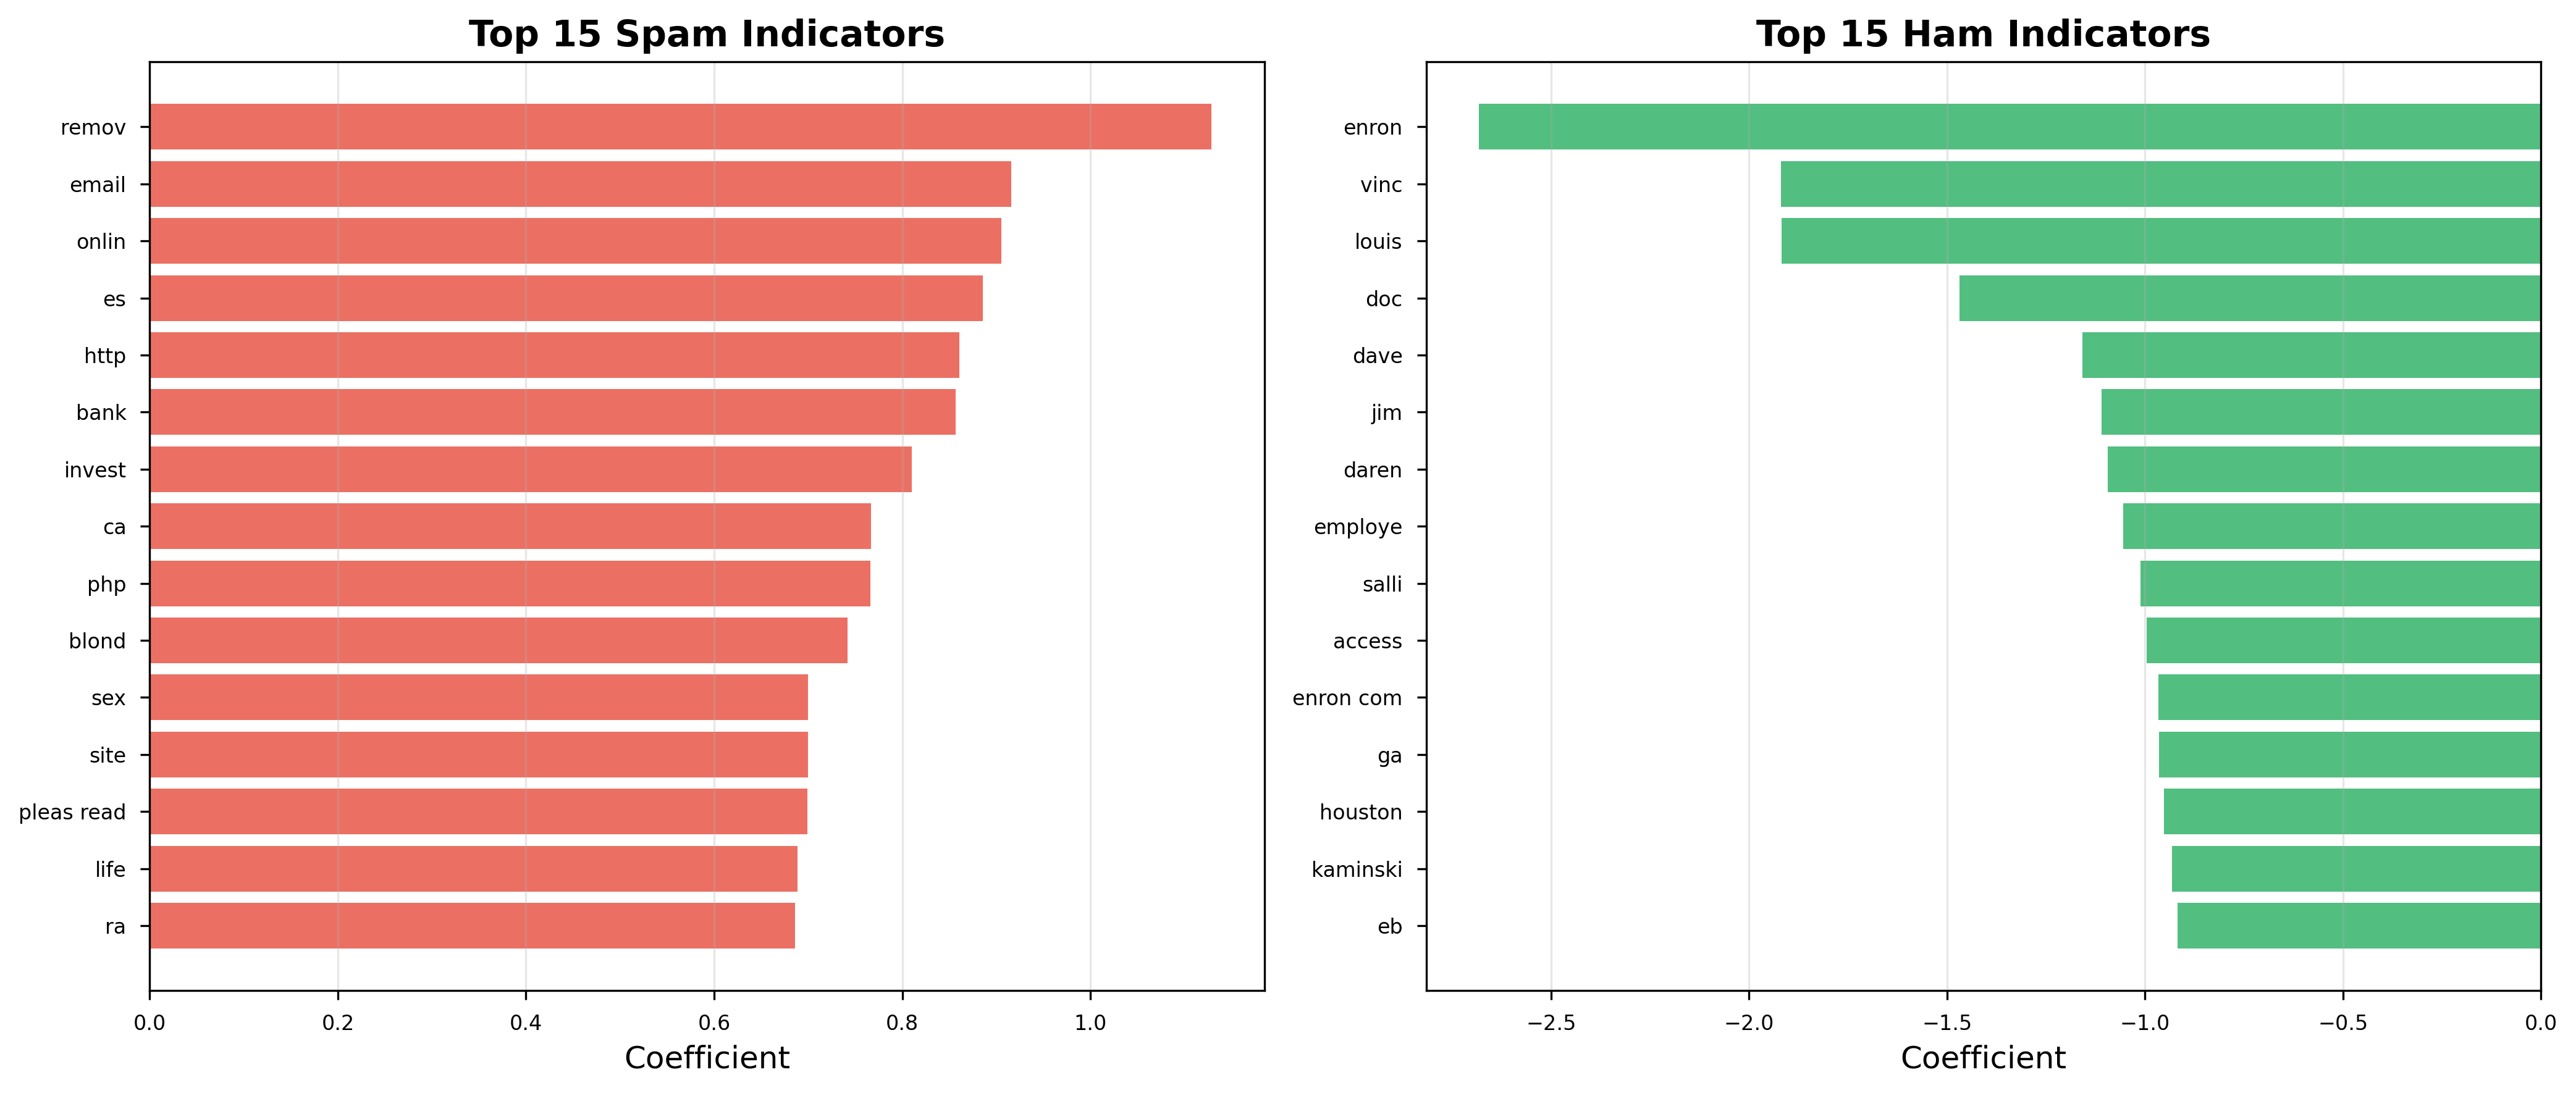

✅ Feature importance saved

📝 Top-5 spam: remov, email, onlin, es, http
📝 Top-5 ham: enron, vinc, louis, doc, dave


In [21]:
print("Extracting feature importance from SVM...")

try:
    svm_model = ensemble.named_estimators_['svm']
    
    if hasattr(svm_model, 'calibrated_classifiers_'):
        svm_base = svm_model.calibrated_classifiers_[0].estimator
    else:
        svm_base = svm_model
    
    coef = svm_base.coef_[0]
    word_features = word_vectorizer.get_feature_names_out()
    word_coef = coef[:len(word_features)]
    
    # Top spam/ham indicators
    top_spam_idx = np.argsort(word_coef)[-15:][::-1]
    top_spam_words = word_features[top_spam_idx]
    top_spam_coef = word_coef[top_spam_idx]
    
    top_ham_idx = np.argsort(word_coef)[:15]
    top_ham_words = word_features[top_ham_idx]
    top_ham_coef = word_coef[top_ham_idx]
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    axes[0].barh(range(len(top_spam_words)), top_spam_coef, color='#e74c3c', alpha=0.8)
    axes[0].set_yticks(range(len(top_spam_words)))
    axes[0].set_yticklabels(top_spam_words)
    axes[0].set_xlabel('Coefficient', fontsize=12)
    axes[0].set_title('Top 15 Spam Indicators', fontsize=14, fontweight='bold')
    axes[0].invert_yaxis()
    axes[0].grid(axis='x', alpha=0.3)
    
    axes[1].barh(range(len(top_ham_words)), top_ham_coef, color='#27ae60', alpha=0.8)
    axes[1].set_yticks(range(len(top_ham_words)))
    axes[1].set_yticklabels(top_ham_words)
    axes[1].set_xlabel('Coefficient', fontsize=12)
    axes[1].set_title('Top 15 Ham Indicators', fontsize=14, fontweight='bold')
    axes[1].invert_yaxis()
    axes[1].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('paper_figures/feature_importance.png', dpi=300, bbox_inches='tight')
    plt.savefig('paper_figures/feature_importance.pdf', bbox_inches='tight')
    plt.show()
    
    print("✅ Feature importance saved")
    print(f"\n📝 Top-5 spam: {', '.join(top_spam_words[:5])}")
    print(f"📝 Top-5 ham: {', '.join(top_ham_words[:5])}")
    
except Exception as e:
    print(f"⚠️ Could not extract: {e}")

## ✅ Summary

In [22]:
print("="*70)
print("ALL PAPER FIGURES AND TABLES GENERATED!")
print("="*70)

print("\n📁 Files in paper_figures/:")
files = sorted(os.listdir('paper_figures'))
for i, f in enumerate(files, 1):
    size = os.path.getsize(f'paper_figures/{f}') / 1024
    print(f"   {i:2d}. {f} ({size:.1f} KB)")

print("\n🎉 Done! Format: PNG (300 DPI) + PDF")
print("="*70)

ALL PAPER FIGURES AND TABLES GENERATED!

📁 Files in paper_figures/:
    1. confusion_matrix.pdf (23.0 KB)
    2. confusion_matrix.png (69.4 KB)
    3. feature_importance.pdf (21.9 KB)
    4. feature_importance.png (117.4 KB)
    5. figure1_dataset_overview.pdf (25.8 KB)
    6. figure1_dataset_overview.png (130.1 KB)
    7. figure2_calibration.pdf (27.8 KB)
    8. figure2_calibration.png (294.8 KB)
    9. figure3_ablation.pdf (22.5 KB)
   10. figure3_ablation.png (104.6 KB)
   11. roc_pr_curves.pdf (21.2 KB)
   12. roc_pr_curves.png (156.2 KB)
   13. table1_corpus_stats.csv (0.1 KB)
   14. table2_calibration.csv (0.1 KB)
   15. table3_performance.csv (0.1 KB)
   16. table4_ablation.csv (0.2 KB)

🎉 Done! Format: PNG (300 DPI) + PDF
